# 00-download_april2020_osmnx_network_metropolis2020

This notebook runs the cities of metropolis>metro_gdf_2020, creates a Network (G,nodes,edges) for a bbox around the city and saves it to db.

This notebook downloads OSMnx data from __April 2020__ because the __mexican 2020 census__ was took place between March 2nd and 27th, 2020. The tests for downloading specific OSMnx dates can be found on notebook 00b.

#### __From OSMnx module: Date must be in form of yyyy-mm-ddThh:mm:ssZ__
#### __Example: '[out:json][timeout:90][date:"2019-10-28T19:20:00Z"]'__

* First part runs for all cities except for ZMVM (Too heavy).
* Second part runs ZMVM by municipality (Bboxes overlap with each other, must drop duplicates)
* Third part are drop duplicates tests.

## Import libraries

In [1]:
main_folder_path = '../../../'

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(main_folder_path))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Load cities

In [3]:
# gdf_mun
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'

query = f"SELECT * FROM {metro_schema}.{metro_table}"
metro_gdf = aup.gdf_from_query(query, geometry_col='geometry')
metro_gdf = metro_gdf.set_crs("EPSG:4326")

city_list = list(metro_gdf.city.unique())

# Show
print(metro_gdf.shape)
print(len(city_list))
print(city_list)
metro_gdf.head(1)

(367, 6)
71
['Aguascalientes', 'Ensenada', 'Mexicali', 'Tijuana', 'La Paz', 'Los Cabos', 'Campeche', 'Laguna', 'Monclova', 'Piedras Negras', 'Saltillo', 'Colima', 'Tapachula', 'Tuxtla', 'Chihuahua', 'Delicias', 'Juarez', 'CDMX', 'ZMVM', 'Durango', 'Celaya', 'Guanajuato', 'Leon', 'Irapuato', 'Acapulco', 'Chilpancingo', 'Pachuca', 'Tulancingo', 'Guadalajara', 'Vallarta', 'Piedad', 'Toluca', 'Morelia', 'Zamora', 'Uruapan', 'Cuautla', 'Cuernavaca', 'Tepic', 'Monterrey', 'Oaxaca', 'Puebla', 'San Martin', 'Tehuacan', 'Queretaro', 'Cancun', 'Chetumal', 'Playa', 'SLP', 'Culiacan', 'Los Mochis', 'Mazatlan', 'Guaymas', 'Ciudad Obregon', 'Hermosillo', 'Nogales', 'Villahermosa', 'Victoria', 'Matamoros', 'Nuevo Laredo', 'Reynosa', 'Tampico', 'Tlaxcala', 'Coatzacoalcos', 'Cordoba', 'Minatitlan', 'Orizaba', 'Poza Rica', 'Veracruz', 'Xalapa', 'Merida', 'Zacatecas']


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,01001,01,001,Aguascalientes,"POLYGON ((-102.10641 22.06035, -102.10368 22.0...",Aguascalientes


## First part - Run function create_osmnx_network for each city (Except for ZMVM) and save

In [4]:
# Save locally?
local_save = False
local_save_dir = main_folder_path + f"data/processed/networks/"
# Save to database?
db_save = True
nodes_table = 'nodes_osmnx_20_point'
edges_table = 'edges_osmnx_20_line'

# Test configuration
# If test, saves locally only (overrides local_save and save_to_db vars.) and runs test_city_lst only
test = False
test_city_lst = ['Aguascalientes']

In [6]:
# Test run
if test:
    # Configuration for test_city_list
    city_list = test_city_lst
    skip_city_list = []
    nodes_processed_city_list = []
    edges_processed_city_list = []
    i = 0
    k = len(city_list)
    # Save configuration
    local_save = True
    db_save = False
# Complete run
else:
    k = len(city_list)
    
    # prevent cities being analyzed several times in case of a crash
    nodes_processed_city_list = []
    edges_processed_city_list = []
    try:
        query = f"SELECT city FROM osmnx.{nodes_table}"
        nodes_processed = aup.df_from_query(query)
        nodes_processed_city_list = list(nodes_processed.city.unique())
        query = f"SELECT city FROM osmnx.{edges_table}"
        edges_processed = aup.df_from_query(query)
        edges_processed_city_list = list(edges_processed.city.unique())
    except:
        nodes_processed_city_list = []
        edges_processed_city_list = []
    
    # PRINT NODES PROGRESS
    missing_cities_nodes = []
    for city in city_list:
        if city not in nodes_processed_city_list:
            missing_cities_nodes.append(city)
    i = len(nodes_processed_city_list)
    print(f'Already processed nodes for ({i}/{k}) cities.')
    print(f'Missing nodes procesing for cities: {missing_cities_nodes}')
    # PRINT EDGES PROGRESS
    missing_cities_edges = []
    for city in city_list:
        if city not in edges_processed_city_list:
            missing_cities_edges.append(city)
    j = len(nodes_processed_city_list)
    print(f'Already processed nodes for ({i}/{k}) cities.')
    print(f'Missing nodes procesing for cities: {missing_cities_edges}')    
    
    # SKIP SPECIFIC CITIES
    skip_city_list = ['ZMVM'] #Skipping 'ZMVM' because of size
    k = k - len(skip_city_list)

# RUN ALL OTHER CITIES
for city in city_list:
    if city not in skip_city_list:
        if (city not in nodes_processed_city_list) and (city not in edges_processed_city_list):
            print("--"*40)
            i = i + 1
            print(f"Starting city {i}/{k}: {city}")
        
            # Load area of interest
            city_gdf = metro_gdf.loc[metro_gdf.city == city]
            aoi = city_gdf.dissolve()
            
            # Create Network
            G,nodes,edges = aup.create_osmnx_network(aoi, 
                                                     how='from_bbox', 
                                                     network_type='all_private', 
                                                     specific_date=(True,'[out:json][timeout:90][date:"2020-04-01T12:00:00Z"]'))
            # Add city data
            nodes['city'] = city
            edges['city'] = city

            # Reset index 
            # Function create_osmnx_network() returns 'osmid' as nodes index and 'u','v' and 'key' as edges index.
            # This indexed columns are not uploaded to the database if kept as index.
            nodes.reset_index(inplace=True)
            edges.reset_index(inplace=True)

            # Save network locally
            if local_save:
                print(f"Uploading {city} nodes locally.")
                nodes.to_file(local_save_dir + f"{city}_apr2020_nodes", driver='GPKG')
                print(f"Uploading {city} edges locally.")
                edges.to_file(local_save_dir + f"{city}_apr2020_edges", driver='GPKG')
            
            # Save network to database
            if db_save:
                print(f"Uploading {city} nodes to database")
                aup.gdf_to_db_slow(nodes, nodes_table, 'osmnx', if_exists='append')
                print(f"Uploading {city} edges to database")
                aup.gdf_to_db_slow(edges, edges_table, 'osmnx', if_exists='append')

        else:
            print("--"*40)
            print(f"{city} already processed. ({i}/{k})")
            
    else:
        print("--"*40)
        print(f"SKIPPED {city}")

Already processed nodes for (70/71) cities.
Missing nodes procesing for cities: ['ZMVM']
Already processed nodes for (70/71) cities.
Missing nodes procesing for cities: ['ZMVM']
--------------------------------------------------------------------------------
Aguascalientes already processed. (70/70)
--------------------------------------------------------------------------------
Ensenada already processed. (70/70)
--------------------------------------------------------------------------------
Mexicali already processed. (70/70)
--------------------------------------------------------------------------------
Tijuana already processed. (70/70)
--------------------------------------------------------------------------------
La Paz already processed. (70/70)
--------------------------------------------------------------------------------
Los Cabos already processed. (70/70)
--------------------------------------------------------------------------------
Campeche already processed. (70/70)

## Second part - Run function create_osmnx_network for ZMVM 
#### (Uploads one municipality at a time, creating bbox overlaps. __Must delete duplicates.__)

In [7]:
# Save to database?
db_save = False
nodes_table = 'nodes_osmnx_20_point'
edges_table = 'edges_osmnx_20_line'

In [6]:
# Filter for ZMVM municipalities
city = 'ZMVM'
zmvm_gdf = metro_gdf.loc[metro_gdf.city == city]
k = len(list(zmvm_gdf.NOMGEO.unique()))
i = 1

for nomgeo in list(zmvm_gdf.NOMGEO.unique()):
    
    print(f"Starting mun {i}/{k}: {nomgeo}")

    # Load area of interest
    mun_gdf = zmvm_gdf.loc[zmvm_gdf.NOMGEO == nomgeo]
    aoi = mun_gdf.dissolve()
    
    # Create Network
    G,nodes,edges = aup.create_osmnx_network(aoi, 
                                             how='from_bbox', 
                                             network_type='all_private', 
                                             specific_date=(True,'[out:json][timeout:90][date:"2020-04-01T12:00:00Z"]'))
    # Add city data
    nodes['city'] = city
    edges['city'] = city

    # Save network to database
    if db_save:
        print(f"Uploading nodes for mun {nomgeo} of {city}.")
        aup.gdf_to_db_slow(nodes, nodes_table, 'osmnx', if_exists='append')
        print(f"Uploading edges for mun {nomgeo} of {city}.")
        aup.gdf_to_db_slow(edges, edges_table, 'osmnx', if_exists='append')

    i = i+1

Starting mun 1/47: Atotonilco de Tula
Extracted min and max coordinates from the municipality. Polygon N:20.04706, S:19.87349, E-99.14251, W-99.31103.
Created OSMnx graph from bounding box.
Converted OSMnx graph to 5952 nodes and 14827 edges GeoDataFrame.
Added column access for edges.
Filtered columns.
Column: osmid in nodes gdf, has a list in it, the column data was converted to string.
Column: name in nodes gdf, has a list in it, the column data was converted to string.
Column: highway in nodes gdf, has a list in it, the column data was converted to string.
Column: maxspeed in nodes gdf, has a list in it, the column data was converted to string.
Uploading nodes for mun Atotonilco de Tula of ZMVM.
Uploading edges for mun Atotonilco de Tula of ZMVM.
Starting mun 2/47: Tizayuca
Extracted min and max coordinates from the municipality. Polygon N:19.90671, S:19.79857, E-98.90298, W-99.02058.
Created OSMnx graph from bounding box.
Converted OSMnx graph to 5457 nodes and 13121 edges GeoData

## Third part - Tests

### Two-adjacent-municipalities test (Analysing how one CDMX municipality and one adjacent ZMVM municipality overlap)
#### __Result:__ Duplicated edges (Same street, same direction, one with city=Atizapán, one with city=Tlanepantla)

In [3]:
# Set muns
test_gdf = metro_gdf.loc[(metro_gdf.NOMGEO == 'Atizapán de Zaragoza') | (metro_gdf.NOMGEO == 'Tlalnepantla de Baz')]

edges_test_gdf = gpd.GeoDataFrame()
nodes_test_gdf = gpd.GeoDataFrame()

for nomgeo in list(test_gdf.NOMGEO.unique()):
    
    print(f"Starting mun: {nomgeo}")

    # Create mun area of interest and network
    mun_gdf = test_gdf.loc[test_gdf.NOMGEO == nomgeo]
    aoi = mun_gdf.dissolve()
    G,nodes,edges = aup.create_osmnx_network(aoi, how='from_bbox', network_type='all_private')

    nodes['city'] = nomgeo
    edges['city'] = nomgeo
    
    nodes_test_gdf = pd.concat([nodes_test_gdf,nodes])
    edges_test_gdf = pd.concat([edges_test_gdf,edges])

Starting mun: Atizapán de Zaragoza
Extracted min and max coordinates from the municipality. Polygon N:19.61221, S:19.51586, E-99.21158, W-99.35441.
Created OSMnx graph from bounding box.
Converted OSMnx graph to 23630 nodes and 55000 edges GeoDataFrame.
Filtered columns.
Loaded 23630 nodes.
Loaded 55000 edges.
Column: osmid in nodes gdf, has a list in it, the column data was converted to string.
Column: lanes in nodes gdf, has a list in it, the column data was converted to string.
Column: name in nodes gdf, has a list in it, the column data was converted to string.
Column: highway in nodes gdf, has a list in it, the column data was converted to string.
Column: maxspeed in nodes gdf, has a list in it, the column data was converted to string.
Column: access in nodes gdf, has a list in it, the column data was converted to string.
Final output 23630 nodes.
Final output 55000 edges.
Starting mun: Tlalnepantla de Baz
Extracted min and max coordinates from the municipality. Polygon N:19.59557

In [4]:
test0 = edges_test_gdf.loc[edges_test_gdf.osmid == '778936799']

print(test0.shape)
test0.head(2)

(48, 19)


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
5880,778936799,6444932087,2339325993,0,False,2,Boulevard Calacoaya,tertiary,<NA>,90.322,"LINESTRING (-99.24158 19.53380, -99.24138 19.5...",NaN,NaN,NaN,NaN,<NA>,NaN,NaN,Atizapán de Zaragoza
5882,778936799,2339327491,2339325996,0,False,2,Boulevard Calacoaya,tertiary,<NA>,9.495,"LINESTRING (-99.23953 19.53458, -99.23961 19.5...",NaN,NaN,NaN,NaN,<NA>,NaN,NaN,Atizapán de Zaragoza


In [5]:
test1 = edges_test_gdf.loc[(edges_test_gdf.osmid == '778936799') & (edges_test_gdf.v == 7272683728) & (edges_test_gdf.u == 2339357322)]
test1

,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
6199,778936799,7272683728,2339357322,0,False,2,Boulevard Calacoaya,tertiary,<NA>,61.939,"LINESTRING (-99.23801 19.53540, -99.23849 19.5...",NaN,NaN,NaN,NaN,<NA>,NaN,NaN,Atizapán de Zaragoza
27136,778936799,7272683728,2339357322,0,False,2,Boulevard Calacoaya,tertiary,<NA>,61.939,"LINESTRING (-99.23801 19.53540, -99.23849 19.5...",NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,Tlalnepantla de Baz


In [6]:
test2 = edges_test_gdf.loc[(edges_test_gdf.osmid == '778936799') & (edges_test_gdf.u == 7272683728) & (edges_test_gdf.v == 2339357322)]
test2

,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
37738,778936799,2339357322,7272683728,0,False,2,Boulevard Calacoaya,tertiary,<NA>,61.939,"LINESTRING (-99.23849 19.53508, -99.23801 19.5...",NaN,NaN,NaN,NaN,<NA>,NaN,NaN,Atizapán de Zaragoza
70221,778936799,2339357322,7272683728,0,False,2,Boulevard Calacoaya,tertiary,<NA>,61.939,"LINESTRING (-99.23849 19.53508, -99.23801 19.5...",NaN,<NA>,NaN,NaN,<NA>,NaN,NaN,Tlalnepantla de Baz


<Axes: >

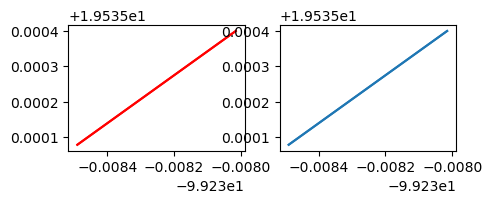

In [7]:
fig,ax = plt.subplots(1,2,figsize=(5,5))
test1.plot(ax=ax[0],color='red')
test2.plot(ax=ax[1])

### Two-adjacent-municipalities test (Loading network from database after dropping duplicates)
#### __Result:__ Success. One edge per street, direction.

In [8]:
from shapely.geometry import Polygon

In [9]:
# Set muns
muns = metro_gdf.loc[(metro_gdf.NOMGEO == 'Atizapán de Zaragoza') | (metro_gdf.NOMGEO == 'Tlalnepantla de Baz')]
aoi_muns = muns.dissolve()

# Create bbox
poly = aoi_muns.geometry
coord_val = poly.bounds
lat_point_list = [coord_val.miny, coord_val.maxy, coord_val.maxy,coord_val.miny]
lon_point_list = [coord_val.minx, coord_val.minx, coord_val.maxx,coord_val.maxx]
polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[polygon_geom]) 

# Load edges within bbox
edges_muns = aup.gdf_from_polygon(polygon,'osmnx','edges_23_line')

# Show
print(edges_muns.shape)
edges_muns.head(2)

(149622, 19)


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
0,654774263,385717876,388428005,0,False,None,Calle Canaleta,residential,None,55.998,"LINESTRING (-99.10545 19.50489, -99.10560 19.5...",None,None,None,None,None,None,None,ZMVM
1,"[908108274, 946587678]",388428002,388428005,0,False,None,Calle Jesús Díaz León,"['residential', 'pedestrian']",None,194.240,"LINESTRING (-99.10545 19.50489, -99.10556 19.5...",None,None,None,None,None,None,None,ZMVM


In [10]:
test3 =edges_muns.loc[edges_muns.osmid == '778936799']
print(test3.shape)
test3.head(2)

(24, 19)


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
8925,778936799,8505335915,2339327487,0,False,2,Boulevard Calacoaya,tertiary,None,33.567,"LINESTRING (-99.24015 19.53432, -99.23985 19.5...",None,None,None,None,None,None,None,ZMVM
8926,778936799,4687800320,2339327487,0,False,2,Boulevard Calacoaya,tertiary,None,23.214,"LINESTRING (-99.24015 19.53432, -99.24035 19.5...",None,None,None,None,None,None,None,ZMVM


In [11]:
test4 = edges_muns.loc[(edges_muns.osmid == '778936799') & (edges_muns.v == 7272683728) & (edges_muns.u == 2339357322)]
test4

,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
84604,778936799,7272683728,2339357322,0,False,2,Boulevard Calacoaya,tertiary,None,61.939,"LINESTRING (-99.23801 19.53540, -99.23849 19.5...",None,None,None,None,None,None,None,ZMVM


In [12]:
test5 = edges_muns.loc[(edges_muns.osmid == '778936799') & (edges_muns.u == 7272683728) & (edges_muns.v == 2339357322)]
test5

,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
84617,778936799,2339357322,7272683728,0,False,2,Boulevard Calacoaya,tertiary,None,61.939,"LINESTRING (-99.23849 19.53508, -99.23801 19.5...",None,None,None,None,None,None,None,ZMVM


<Axes: >

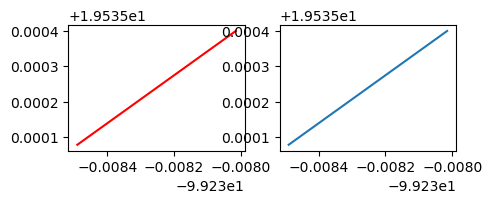

In [13]:
fig,ax = plt.subplots(1,2,figsize=(5,5))
test4.plot(ax=ax[0],color='red')
test5.plot(ax=ax[1])

In [ ]:
# Compare columns with db data
#city_list = ['Aguascalientes']

#for city in city_list:
    # Load area of interest
#    city_gdf = metro_gdf.loc[metro_gdf.city == city]
#    aoi = city_gdf.dissolve()

#    nodes_gdf = aup.gdf_from_polygon(aoi, 'osmnx', 'nodes', geom_col="geometry")
#    nodes_gdf = nodes_gdf.set_crs("EPSG:4326")
    
#    edges_gdf = aup.gdf_from_polygon(aoi, 'osmnx', 'edges', geom_col="geometry")
#    edges_gdf = edges_gdf.set_crs("EPSG:4326")

In [ ]:
# Check available data
#city_list = ['Aguascalientes']

#for city in city_list:
    # Load area of interest
#    city_gdf = metro_gdf.loc[metro_gdf.city == city]
#    aoi = city_gdf.dissolve()

#    nodes_gdf = aup.gdf_from_polygon(aoi, 'osmnx', 'nodes_23_point', geom_col="geometry")
#    nodes_gdf = nodes_gdf.set_crs("EPSG:4326")
    
#    edges_gdf = aup.gdf_from_polygon(aoi, 'osmnx', 'edges_23_line', geom_col="geometry")
#    edges_gdf = edges_gdf.set_crs("EPSG:4326")

### Delete duplicates test

In [24]:
# gdf_mun
edges_schema = 'osmnx'
edges_table = 'edges_23_line'
c = 'ZMVM'

query = f"SELECT * FROM {edges_schema}.{edges_table} WHERE \"city\" LIKE \'{c}\'"
zmvm_edges_gdf = aup.gdf_from_query(query, geometry_col='geometry')
zmvm_edges_gdf = zmvm_edges_gdf.set_crs("EPSG:4326")

# Show
print(zmvm_edges_gdf.shape)
zmvm_edges_gdf.head(1)

(1033909, 19)


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
0,874524421,8141004109,7898236498,0,False,None,None,service,None,12.673,"LINESTRING (-99.26017 19.48469, -99.26022 19.4...",None,None,None,None,None,None,None,ZMVM


In [26]:
test_deldups = zmvm_edges_gdf.drop_duplicates(subset=['osmid','v', 'u','key'], keep='first')

# Show
print(test_deldups.shape)
test_deldups.head(1)

(1033909, 19)


,osmid,v,u,key,oneway,lanes,name,highway,maxspeed,length,geometry,bridge,ref,junction,tunnel,access,width,service,city
0,874524421,8141004109,7898236498,0,False,None,None,service,None,12.673,"LINESTRING (-99.26017 19.48469, -99.26022 19.4...",None,None,None,None,None,None,None,ZMVM
